### *`Fashion MNIST Classification using PyTorch`*

- How to classify clothing items from the Fashion MNIST database. 
- The Fashion MNIST dataset is included in torchvision.datasets and can easily be imported and loaded.
- we will demonstrate how to work with image data that represents ten different classes of clothing items
- and how to develop a network architecture that includes ten neurons whose outputs represent the `probability of the classes`.
![alt text](<pytorch-cnn-based-classification-model-with-fashion-mnist_02 (1).jpg>)


#### Table of Contents
* [1. Prepare the DataLoader](#1.-Prepare-the-DataLoader)
* [2. Dataset Visualization](#2.-Dataset-Visualization)
* [3. Model Architecture](#3.-Model-Architecture)
* [4. Multi Layer Perceptron Model Implementation](#4.-Multi-Layer-Perceptron-Model-Implementation)
* [5. Inference Results](#5.-Inference-Results)
* [6. Conclusion](#6.-Conclusion)

### Import Dependencies
- Libraries
- Dataset
- Transforms

In [1]:
# To view model summary

# !pip install -q torchinfo

In [2]:
import torch
from torchvision import datasets, transforms

# Load Fashion MNIST Dataset (Without Normalization)
# transforms -> A function/transform that takes in a PIL image and returns a transformed version.
dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
for i, c in dataset:
    print(i)    # Image Tensor
    print(c)    # Class Label
    break

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [4]:
# Stack all images into Single Tensor and Compute the Mean and Standard Deviation
# .view(-1) -> reshape it to vector (1d Tensor)
# all_pixels = torch.cat([img.view(-1) for img, _ in dataset])
all_pixels = torch.stack([img.view(-1) for img, _ in dataset])

mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Mean = {mean:.4f}")
print(f"Standard Deviation = {std:.4f}")

Mean = 0.2860
Standard Deviation = 0.3530


In [5]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import random
import time

%matplotlib inline

### Set seed for reproducibility

In [6]:
# We have more than one value to set seed

def set_seeds():
    # Set random seed value
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    # Fix seed to make training deterministic.
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds()

### 1. Prepare the DataLoader

- The Fashion MNIST dataset can be easily downloaded with `torchvision.datasets` and contains 70,000 images partitioned into 60,000 for training and 10,000 for test.
- We will perform validation and final prediction on the test dataset.

#### 1.1. Input Feature Transformation and Normalization

- Since we are now working with `images as the input`, we need to find some `logical way to represent the image data as a set of features`.
- A `naive approach` that actually works fairly well for this dataset is to just `assume that the pixel intensities are the features`. And one way to transform the image data into a set of features that we can `process is to flatten the 2D array into a 1D array`. 
- The `28x28` input image thus becomes a 1D array containing `784` features. Notice that we also `normalize the pixel intensities to be in the range [0, 1]`. This is very common when working with image data which helps the model train more efficiently. Also, using the pixel intensities as features is a naive approach that we are using intentionally here to keep things simple. 
- As we will see in subsequent posts, we will learn about `convolutional neural networks (CNNs)`, which use more advanced techniques for `representing and processing image data in neural networks`.

In [7]:
# Step 1: Download the training set without normalization
raw_transform = transforms.Compose([transforms.ToTensor()])
raw_train_set = datasets.FashionMNIST(root='./F_MNIST_Data', download=True, train=True, transform=raw_transform)

raw_train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./F_MNIST_Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
# Step 2: Compute mean and std from the training set
all_pixels = torch.cat([img.view(-1) for img, c in raw_train_set])

# mean = all_pixels.mean() -> tensor(0.2860)
# mean = all_pixels.mean().item() -> 0.2860

mean = all_pixels.mean().item()
mean = all_pixels.std().item()

print(f"Computed Mean: {mean:.4f}, Computed Std: {std:.4f}")

Computed Mean: 0.3530, Computed Std: 0.3530


In [9]:
# Step 3: Define the new transform using the computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean, ), (std, ))
])

# Step 4: Reload datasets with proper normalization

# train set
train_set = datasets.FashionMNIST(root='./F_MNIST_Data', download=True, train=True, transform=transform)

# test set
val_set = datasets.FashionMNIST(root='./F_MNIST_Data', download=True, train=False, transform=transform)


print("Total Train Images:", len(train_set))
print("Total Val Images:", len(val_set))

Total Train Images: 60000
Total Val Images: 10000


- To avoid the MLP network from learning the sequence pattern in the dataset
    - we will shuffle the train dataset.
    - A batch size is determined based on the compute resource available. 
    - As this is a relatively less compute intensive training we can set the `batch_size = 64`.

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=64)

train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x27164d0a120>,
 <torch.utils.data.dataloader.DataLoader at 0x27164cb7390>)

The Fashion MNIST contains 10 classes as follows:

```html
Label	Description
0	    T-shirt/top
1	    Trouser
2	    Pullover
3	    Dress
4	    Coat
5	    Sandal
6	    Shirt
7	    Sneaker
8	    Bag
9	    Ankle boot
```

In [11]:
# class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"}

### 2. Dataset Visualization


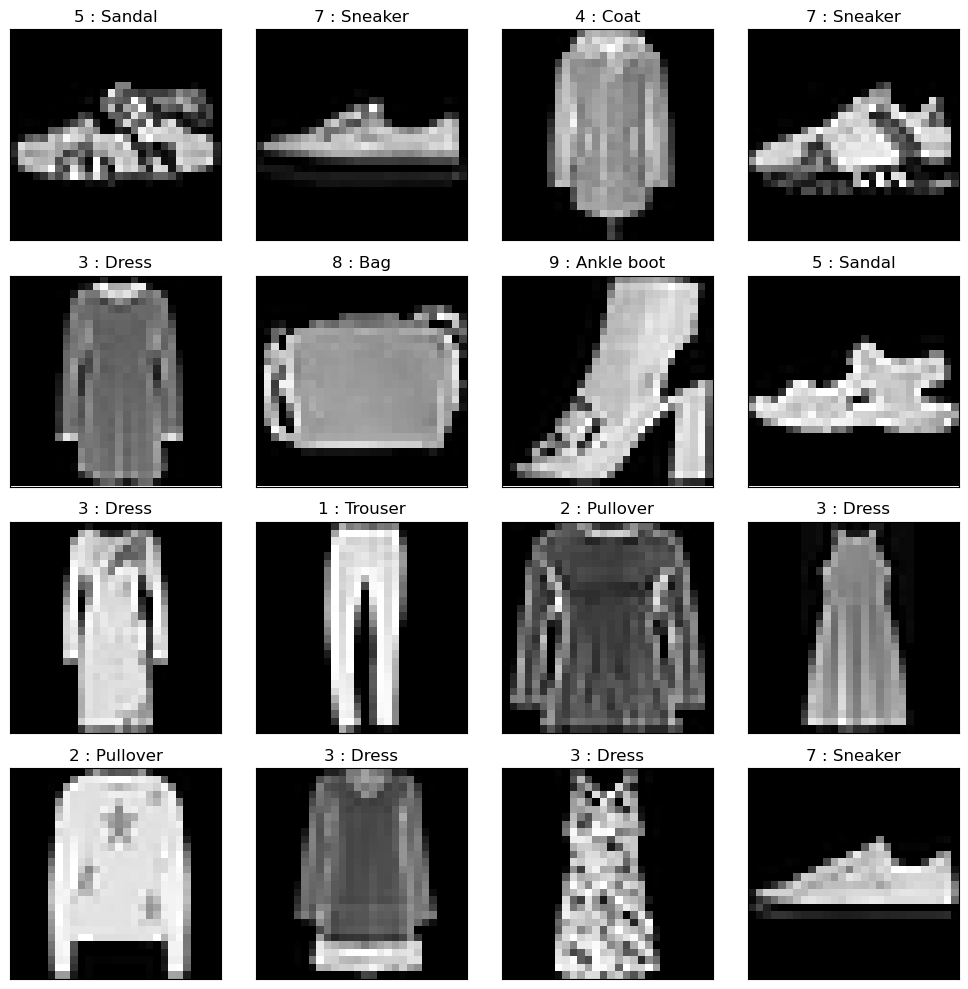

In [12]:
def visualize_images(train_loader, num_images=20):
    fig = plt.figure(figsize=(10, 10))

    # Iterate over the First Batch
    images, labels = next(iter(train_loader))

    # To Calc. Number of Columns and Rows in Subplots
    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]

        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(image), cmap='gray')
        ax.set_title(f"{label.item()} : {class_mapping[label.item()]}")
    
    fig.tight_layout()
    plt.show()


visualize_images(train_loader, num_images=16)

### 3 Deep Neural Network Architecture

- The network architecture shown below has `multiple layers`.
- An `input layer`, `five hidden layers`, and an `output layer`. 

1. **Input Data**: The image input data is `pre-processed (flattened)` from a 2-Dimensional array `[28x28]` to 1-Dimensional vector of length `[784x1]` where the elements in this input vector are the normalized pixel intensities.

2. **Hidden Layers**: We have five hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a `non-linear activation function` (e.g., **ReLU**, Sigmoid, etc.).

3. **Output Layer**: We now have `ten neurons` in the output layer to represent the ten different classes (cloth items: 0 to 9), instead of a single neuron as in the regression example or binary classification example.

4. **Dense Layers**: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. 

5. The **weights** associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.

6. **Softmax Function**: The values from each of the neurons in the output layer are pased through a `log_softmax()` function to `produce a probability score` for each of the ten cloth items in the dataset.

6. **Network Output**: The network output ($y’$), is a `vector of length ten, that contains the probabilities of each output neuron`. Predicting the class label simply requires passing ($y'$) through the `argmax` function to determine the index of the predicted label.

6. **Loss Function**: The loss function used is **Negative Log Likelihood Loss**. It is computed from the ground truth labels ($y$) and the output log probabilities of the network ($y'$). Note that $y$ and $y'$ are both matrices whose shape is `(Bacth Size, Num Classes)`.

- **Backpropagation** is used to compute the gradient of the loss with respect to the weights in the network. 

- An **Adam optimizer** is used to update the weights in the neural network.

<img src='https://www.dropbox.com/scl/fi/56ks2wo5pem1m58djqsi8/MLP-with-Fashion-MNIST-Pipeline.png?rlkey=b7is8m2cz222fa6x88px2ll79&st=qvlv5i5f&dl=1' align='center' width='1000'>

### 4. Multi Layer Perceptron Model Implementation.

- MLP (Multi-Layer Perceptron) model for classifying images into `10` classes using PyTorch `nn` Module.
- The model consists of five fully connected layers with `ReLU` activations, batch normalization, and dropout for regularization. 
- The input layer processes `28x28` images (flattened to `784` features), and the output layer uses a log-softmax activation function to produce probabilities for the `10` classes.
- we use `log-softmax` at the `output layers`, as `Negative Log Likelihood Loss` expects the model's outputs in terms of `log probabilities`. 
- `Dropout` is used to `prevent overfitting` by randomly `setting some of the activations to zero during training`, and this is compensated by a scale factor to `maintain the overall sum of activations`.

In [13]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.fc0 = nn.Linear(784, 512)
        self.bn0 = nn.BatchNorm1d(512)

        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Flatten the Input Image
        x = x.view(x.shape[0], -1)  # (B, 784) --->> (28, 28) = 784

        # First fully connected layer with ReLU, batch norm, and dropout
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)

        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Output Layer with Softmax Activation
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x


# Instantiate the model.
mlp_model = MLP(num_classes=10)

mlp_model

MLP(
  (fc0): Linear(in_features=784, out_features=512, bias=True)
  (bn0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Let's look at the parameters and the output shape after each layers.

In [14]:
# A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
# Display the model summary.

print(summary(mlp_model, input_size=(1, 1, 28, 28), row_settings=['var_names']))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

#### **4.1. Training Configuration**

In [15]:
criterion = F.nll_loss  # Negative Log Likelihood Loss
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2)

EPOCHS = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#### **4.2. Model Training**

For training the model, input images, and the labels has to be on the same device, either on `cuda` or `cpu`.

In [25]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    model.to(device)
    # To Calc. the Average Loss
    running_loss = 0
    # To Calc. Accuracy
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy


def validation(model, val_loader, criterion, device):
    model.eval()
    model.to(device)

    # To Calc. the Average Loss
    running_loss = 0
    # To Calc. Accuracy
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)  # (B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

We will train for **40 epochs** and plot the training accuracy and loss.

In [26]:
def main(model, train_loader, val_loader, epochs=5, device='cuda'):
    # List of Losses and accuracies for each epoch for training set and validation set
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

With an learning rate of 0.01 our MLP Model achieved a highest val accuracy of **90.39%**.

Epoch 01/40 - Train Loss: 0.1879, Train Accuracy: 93.01% - Val Loss: 0.2964, Val Accuracy: 89.72%
Epoch 02/40 - Train Loss: 0.1866, Train Accuracy: 93.02% - Val Loss: 0.2939, Val Accuracy: 89.73%
Epoch 03/40 - Train Loss: 0.1813, Train Accuracy: 93.24% - Val Loss: 0.3084, Val Accuracy: 89.34%
Epoch 04/40 - Train Loss: 0.1788, Train Accuracy: 93.38% - Val Loss: 0.2989, Val Accuracy: 89.96%
Epoch 05/40 - Train Loss: 0.1748, Train Accuracy: 93.43% - Val Loss: 0.2966, Val Accuracy: 89.74%
Epoch 06/40 - Train Loss: 0.1751, Train Accuracy: 93.44% - Val Loss: 0.2871, Val Accuracy: 90.28%
Epoch 07/40 - Train Loss: 0.1683, Train Accuracy: 93.77% - Val Loss: 0.3059, Val Accuracy: 89.72%
Epoch 08/40 - Train Loss: 0.1708, Train Accuracy: 93.69% - Val Loss: 0.2946, Val Accuracy: 90.07%
Epoch 09/40 - Train Loss: 0.1656, Train Accuracy: 93.81% - Val Loss: 0.2971, Val Accuracy: 90.22%
Epoch 10/40 - Train Loss: 0.1616, Train Accuracy: 93.93% - Val Loss: 0.2967, Val Accuracy: 90.23%
Epoch 11/40 - Train 

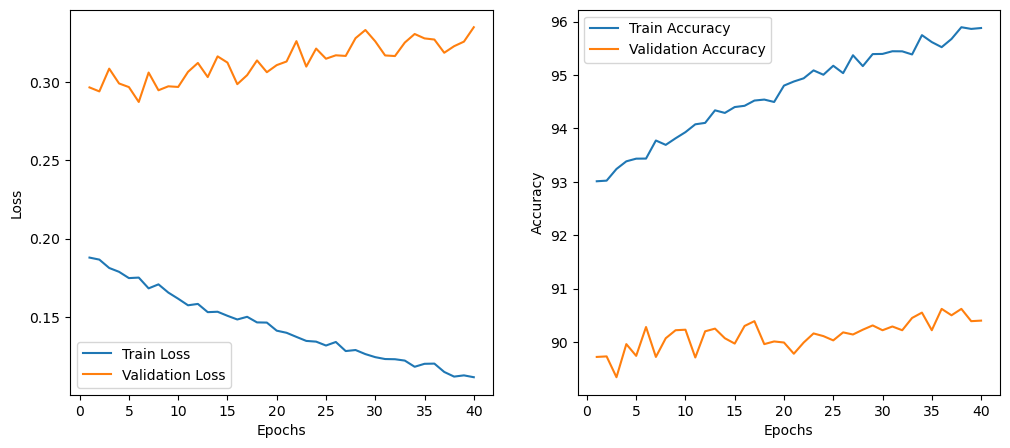

In [27]:
main(mlp_model, train_loader, val_loader, epochs=EPOCHS, device=DEVICE)

## 5. Inference Results

- Predict the results for all the test images, as shown in the code below. 
- we call the `next(iter(val_loader))` to retrieve all the predictions of the first batch, and then we select a specific index from the batch outputs and print out the predicted scores for each class.

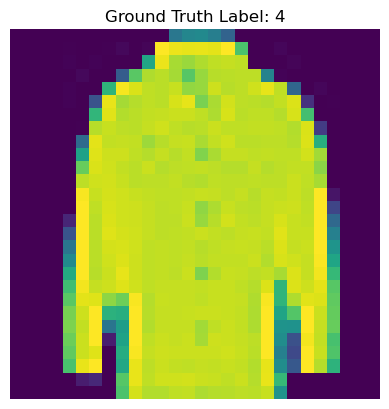

In [28]:
images, gt_labels = next(iter(val_loader))
rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize=12)
plt.axis("off")
plt.show()

In [29]:
# Formatting
bold = f"\033[1m"
reset = f"\033[0m"

In [30]:
mlp_model.eval()

with torch.no_grad():
    batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
        print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
        print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.000
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.053
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.945
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.002
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.000
Class: 9 - Ankle boot, Probability: 0.000


#### **5.1. Confusion  matrix**

- Common metric that is used to summarize the results of a classification problem. 
- The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted lables from the network.
- The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts).
- Generating a confusion matrix is accomplished by calling the `confusion_matrix` from `sklearn.metrics`, which takes two required arguments which are the list of ground truth labels and the associated predicted lables.

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_outputs.softmax(
            dim=1)  # along num of classes dimension

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()

In [32]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

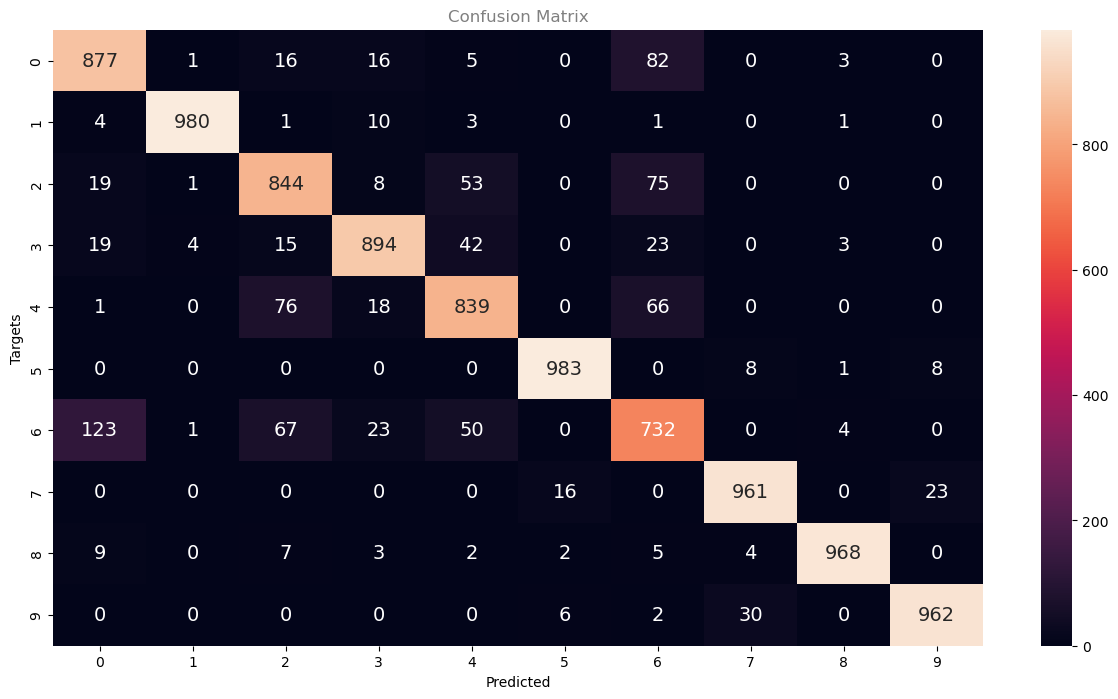

In [33]:
cm = confusion_matrix(y_true=val_target_labels, y_pred=val_predicted_labels)

plt.figure(figsize=[15, 8])

# Plot the confusion matrix as a heatmap.
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()

## 6. Conclusion

In this notebook, we introduced a simple approach for how to model image data for use in a densely connected network to perform multinomial classification. In the next notebook, we will learn about Convolutional Neural Networks (CNNs) that are specifically designed to process image data. The following link contains a really nice interactive web-based animation of several well-known CNN architectures, which is a great place to start getting familiar with them.

* 6.1. https://tensorspace.org/html/playground/lenet.html
* 6.2. https://poloclub.github.io/cnn-explainer/